# Data cleaning

This notebook is based on Kaggle <a href="https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard">kernel</a>.

Interesting moments:
- Removed only features with same value for all entries.
- Used constant value, mode and mean for empty values filling.
- Used Box-Cox transforming. <a href="http://onlinestatbook.com/2/transformations/box-cox.html">Link to paper</a>

In [1]:
#import some necessary librairies
import sys
sys.path.append("../../dstoolkit/")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

color = sns.color_palette()
sns.set_style('darkgrid')

import warnings

def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from eda import missing_values_ratio_per_feature

## Read data

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [33]:
train.drop('Id', inplace=True, axis=1)

In [34]:
test.drop('Id', inplace=True, axis=1)

## Outliers detection

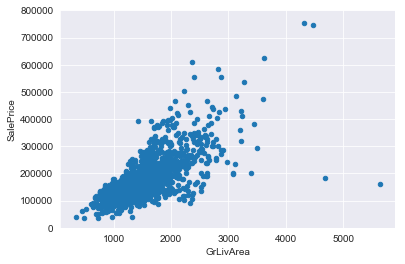

In [3]:
data = pd.concat([train.SalePrice, train.GrLivArea], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))

In [4]:
# Remove outliers in right-bootom side
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

## Missing data processing

In [5]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

In [6]:
# Create all data frame
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)
all_data.drop('SalePrice', axis=1, inplace=True)


In [7]:
missing_values_df = missing_values_ratio_per_feature(all_data)

In [10]:
missing_values_df.head(20)

,Feature,Ratio,Count
0,PoolQC,99.691,2908
1,MiscFeature,96.400,2812
2,Alley,93.212,2719
3,Fence,80.425,2346
4,FireplaceQu,48.680,1420
5,LotFrontage,16.661,486
6,GarageQual,5.451,159
7,GarageCond,5.451,159
8,GarageFinish,5.451,159
9,GarageYrBlt,5.451,159


**PoolQC** : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

In [11]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

**MiscFeature** : data description says NA means "no misc feature"

In [12]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

**Alley** : data description says NA means "no alley access"

In [13]:
all_data["Alley"] = all_data["Alley"].fillna("None")

**Fence** : data description says NA means "no fence"

In [14]:
all_data["Fence"] = all_data["Fence"].fillna("None")

**FireplaceQu** : data description says NA means "no fireplace"

In [15]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

**LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [16]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

In [17]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

**GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [18]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

**BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [19]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

**BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no basement.

In [20]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

**MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [21]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

**MSZoning (The general zoning classification)** : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [22]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

**Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [23]:
all_data = all_data.drop(['Utilities'], axis=1)

**Functional** : data description says NA means typical

In [24]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

**Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [25]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

**KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [26]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

**Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [27]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

**SaleType** : Fill in again with most frequent which is "WD"

In [29]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

**MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [30]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Check if missing values exists

In [31]:
missing_values_ratio_per_feature(all_data)

,Feature,Ratio,Count


## Save cleaned data

In [36]:
train = all_data[:ntrain]
test = all_data[ntrain:]

train.to_csv('../data/cleaned_train.csv')
test.to_csv('../data/cleaned_test.csv')